<a href="https://colab.research.google.com/github/renzasprec/Air-Passenger/blob/main/AirPassengers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import statsmodels.api as sm
from statsmodels.tsa.api import SARIMAX
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [6]:
# preferences
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
# default figure size
sns.mpl.rc('figure', figsize=(16,6))
# default font size
sns.mpl.rc('font', size=10)

# Load Data

In [7]:
data = pd.read_csv('AirPassengers.csv')

In [8]:
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
data.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


Air passenger data contains monthly data.

Convert `Month` column to date index.

In [10]:
date_index = pd.date_range(start='1949', end='1960-12-31', freq='MS')
data.index = date_index

# Data Splitting

Split data to 80% train and 20% validation.

In [11]:
train = data.iloc[:int(len(data)*.8)]
validation = data.iloc[int(len(data)*.8):]

# Data Exploration and Preparation

Plot the data.

Text(0, 0.5, 'No. of Passengers')

<Figure size 1200x800 with 0 Axes>

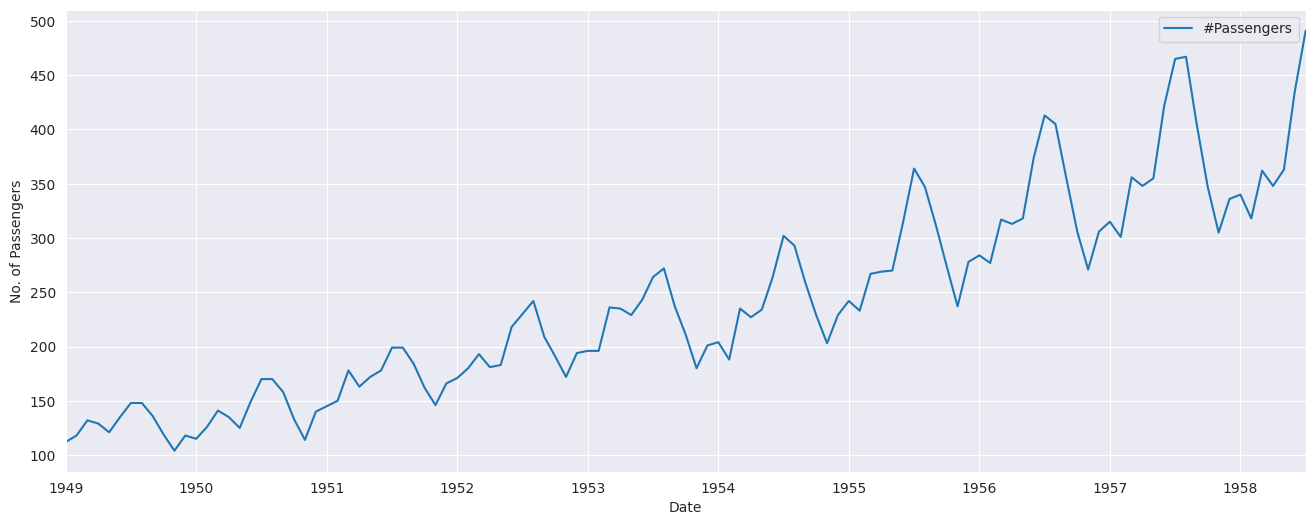

In [12]:
fig = plt.figure(figsize=(12,8))
train.plot()
plt.xlabel('Date')
plt.ylabel('No. of Passengers')

The plot above shows an increasing mean and variance, and the presence of a seasonal trend.

To address the increasing variance, we used Box-Cox transform.

In [13]:
from scipy.stats import boxcox

In [14]:
train['boxcox_transformed'], lam = boxcox(train['#Passengers'])

<ipython-input-14-414303138895>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['boxcox_transformed'], lam = boxcox(train['#Passengers'])


In [15]:
train.head()

,Month,#Passengers,boxcox_transformed
1949-01-01,1949-01,112,5.255124
1949-02-01,1949-02,118,5.319689
1949-03-01,1949-03,132,5.458914
1949-04-01,1949-04,129,5.430309
1949-05-01,1949-05,121,5.350804


Plot of the data with box-cox transformed values.

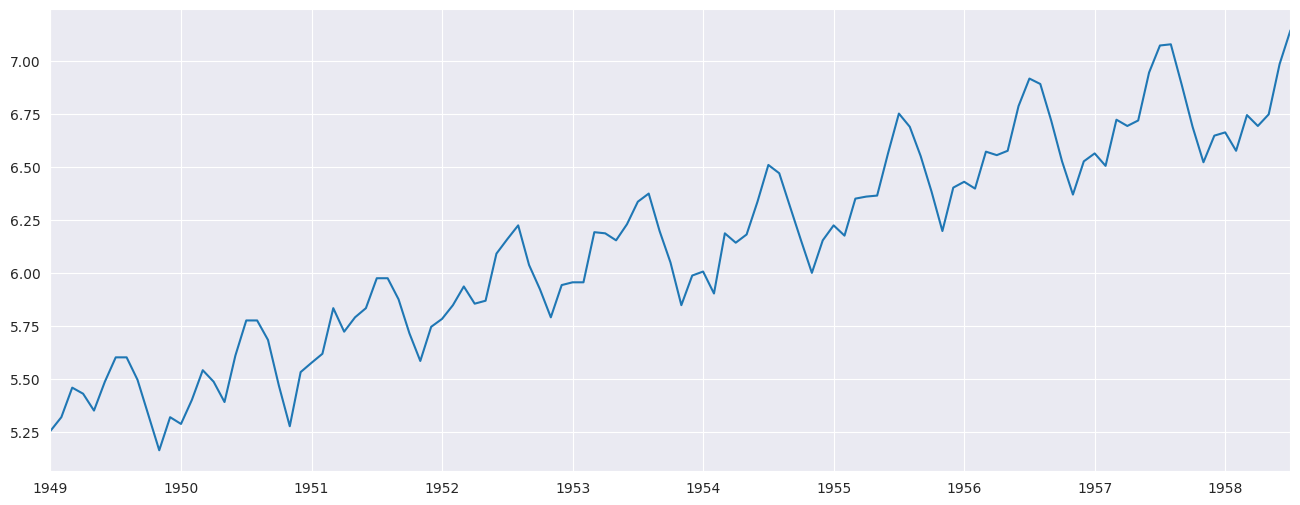

In [16]:
fig = train['boxcox_transformed'].plot()

Investigate the ACF and PACF of the transformed data.

In [17]:
# calculate the number of lags to be investigated
lags = int(10*np.log10(len(train)))
print(lags)

20


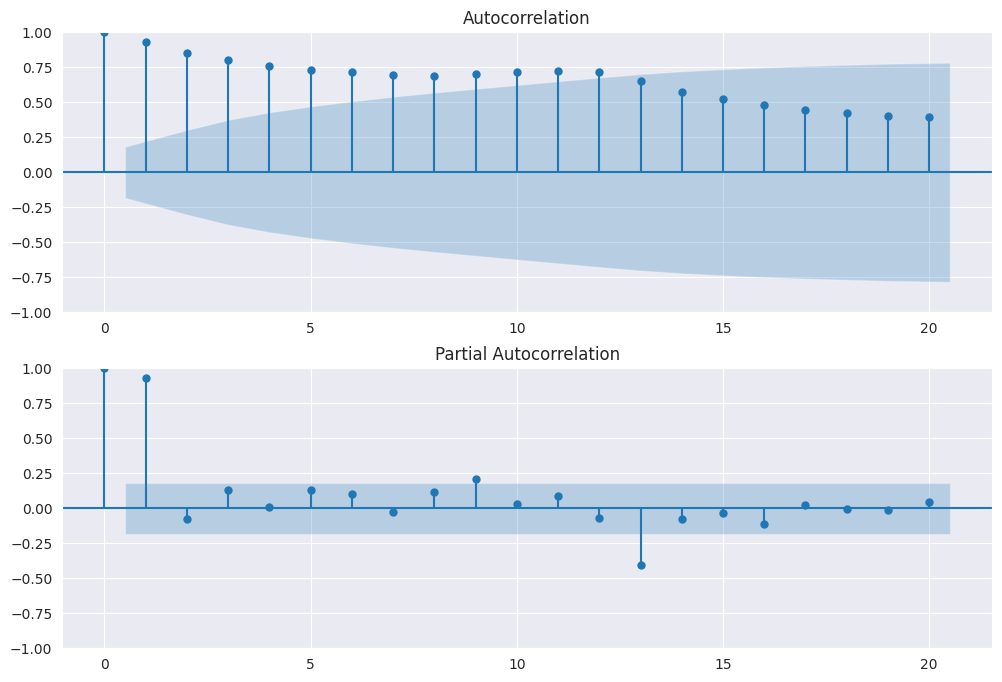

In [18]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(train['boxcox_transformed'], lags=lags, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(train['boxcox_transformed'], lags=lags, ax=ax2)

We address the gradual decrease in ACF using a differencing component. The spike at around 12-13 in the PACF indicates a need for a seasonal component.

# Model Fitting

In [19]:
mod = SARIMAX(
    endog = train['boxcox_transformed'],
    order = (1, 0, 1), # order 1 for AR and M
    seasonal_order = (1, 0, 0, 12) # capture yearly seasonality
).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Investigate results of the model.

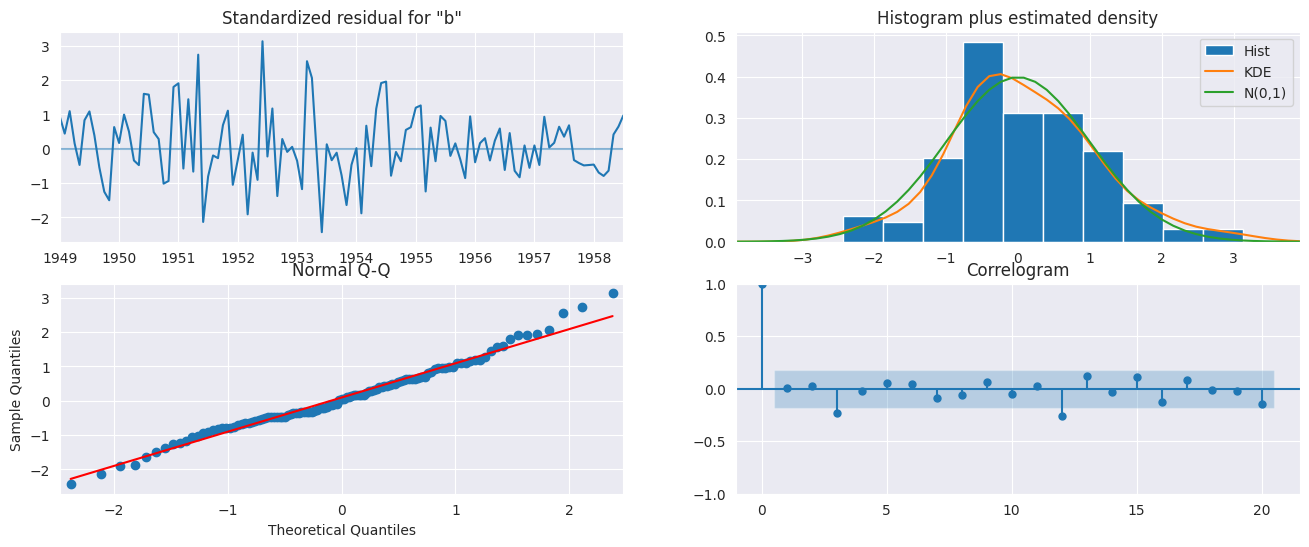

In [20]:
fig = mod.plot_diagnostics(lags=lags)

<Figure size 1200x400 with 0 Axes>

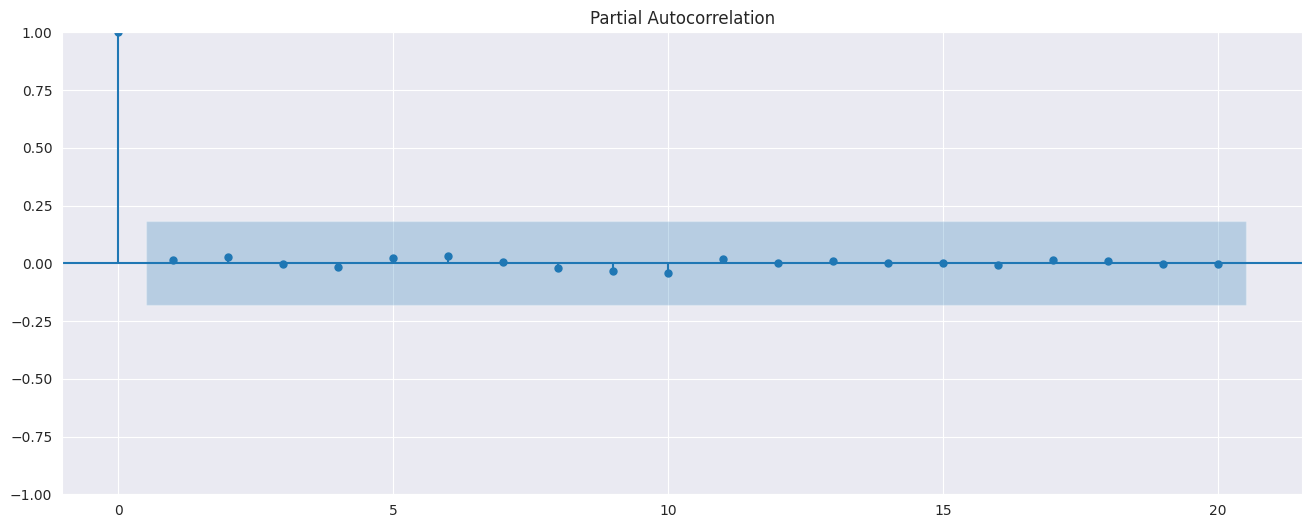

In [21]:
fig = plt.figure(figsize=(12,4))
fig = plot_pacf(mod.resid, lags=lags)

In [22]:
from statsmodels.stats.stattools import durbin_watson

In [23]:
durbin_watson(mod.resid)

0.9879264512003918

In [24]:
from statsmodels.tsa.deterministic import DeterministicProcess

Add Fourier terms to address semi-annual seasonality.

In [25]:
fourier_terms = DeterministicProcess(
    index = train.index,
    period = 6,
    order = 0,
    seasonal = False,
    fourier = 2
)

In [26]:
mod = SARIMAX(
    endog = train['boxcox_transformed'].diff(12).dropna(),
    exog = fourier_terms.in_sample()[12:],
    order = (1, 1, 1), # order 1 for AR, I, and M
    seasonal_order = (1, 0, 1, 12) # capture yearly seasonality
).fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Model results

In [27]:
print(mod.summary())

                                     SARIMAX Results                                      
Dep. Variable:                 boxcox_transformed   No. Observations:                  103
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 168.604
Date:                            Mon, 03 Feb 2025   AIC                           -319.207
Time:                                    06:47:37   BIC                           -295.583
Sample:                                01-01-1950   HQIC                          -309.641
                                     - 07-01-1958                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin(1,6)      -0.0049      0.003     -1.689      0.091      -0.011       0.001
cos(1,6)       0.0054      0.003   

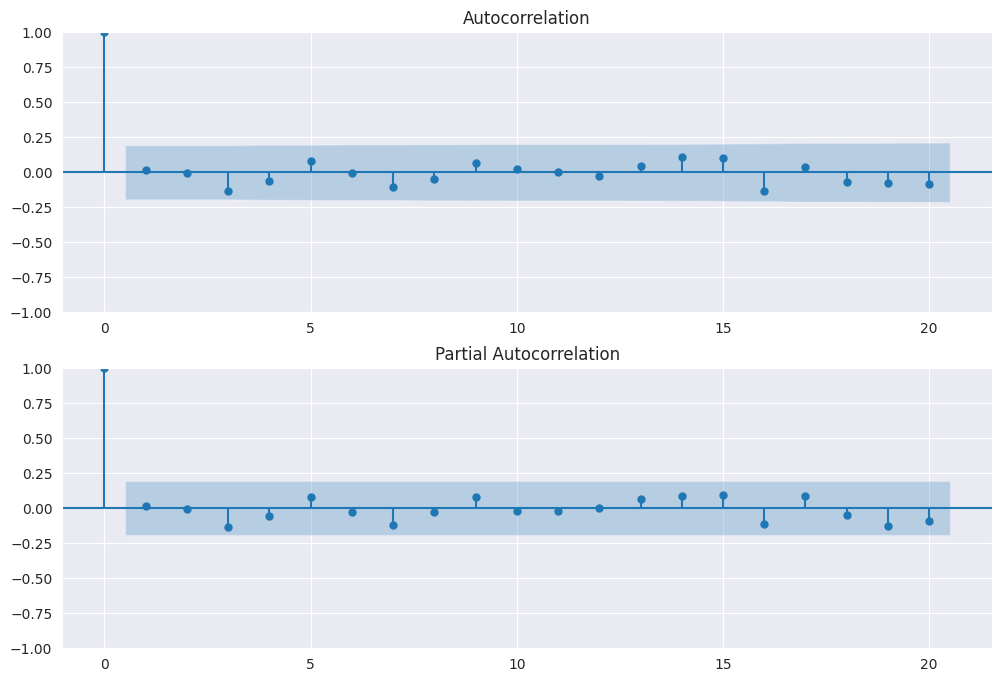

In [28]:
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(12,8))
fig = plot_acf(mod.resid, lags=lags, ax=ax1)
fig = plot_pacf(mod.resid, lags=lags, ax=ax2)

Checking if the model follows the assumption using Durbin-Watson statistic

In [29]:
durbin_watson(mod.resid)

1.9567928587607784

A value close to 2 suggests that there is no autocorrelation of the residuals.

Investigate Ljung-Box Q Statistic of the model.

In [30]:
from statsmodels.tsa.stattools import acf

In [31]:
r, q, p = acf(mod.resid, fft=True, qstat=True)

In [32]:
dat = np.c_[np.arange(1,lags+1), r[1:], q, p]
table = pd.DataFrame(dat, columns=['lags', 'AR', 'Q', 'P(>Q)']).set_index('lags')

In [33]:
print(table)

            AR          Q     P(>Q)
lags                               
1.0   0.016854   0.030118  0.862223
2.0  -0.007216   0.035694  0.982312
3.0  -0.132860   1.944744  0.583954
4.0  -0.060115   2.339523  0.673583
5.0   0.078421   3.018205  0.697179
6.0  -0.006753   3.023290  0.805918
7.0  -0.102282   4.201844  0.756258
8.0  -0.047229   4.455778  0.813841
9.0   0.068012   4.987978  0.835355
10.0  0.022567   5.047202  0.888003
11.0  0.004001   5.049084  0.928766
12.0 -0.029391   5.151750  0.952717
13.0  0.044789   5.392807  0.965498
14.0  0.111068   6.891859  0.938800
15.0  0.103034   8.196546  0.915661
16.0 -0.131671  10.351749  0.847625
17.0  0.039362  10.546595  0.879141
18.0 -0.072166  11.209229  0.885268
19.0 -0.076254  11.957861  0.887419
20.0 -0.082512  12.844974  0.883936


Result of the Q statistic shows that the residuals for the model up to the 21st lag are not correlated.

Check if the time series is stationary with Augmented Dickey-Fuller test.

In [34]:
from statsmodels.tsa.stattools import adfuller

Perform Augmented Dickey-Fuller test on the double differenced data. First, to account for the seasonal differencing `diff(12)`, and secondly, to account for the first-order differencing `diff()`.

In [73]:
adf_results = adfuller(train['boxcox_transformed'].diff(12).diff().dropna(), maxlag=lags, regression='n')

In [74]:
adf_results = pd.Series(adf_results, index = ['adf', 'pvalue', 'usedlag', 'nobs', 'critical_values', 'icbest'])

In [75]:
print(f'ADF statistic: {adf_results["adf"]}')
print(f'Critical Values: {adf_results["critical_values"]}')

ADF statistic: -3.9677848134252858
Critical Values: {'1%': -2.59103, '5%': -1.944357046639232, '10%': -1.6141691577503428}


The ADF statistic is less than the critical value at 1%. This means that we can reject the null and conclude that the time series is stationary with 99% confidence.

# Evaluation of Model Forecast Against Validation Data

In [35]:
forecasts = mod.get_forecast(
    steps = len(validation),
    exog = fourier_terms.out_of_sample(forecast_index=validation.index, steps = len(validation))
    )
forecasts = forecasts.predicted_mean

The predictions of the model are for the differentiated and Box-Cox transformed data.

In [36]:
index = pd.date_range(
    start = train.index[-12],
    end = validation.index[-1],
    freq = 'MS'
)

In [37]:
dat = pd.DataFrame(np.r_[train['boxcox_transformed'][-12:], forecasts], columns=['Forecasts'])
dat.index = index

In order to undo the differencing by 12 periods, iterate through each data starting from the start date of the validation data.

In [38]:
for (i, j) in zip(dat.index[12:], dat.index):
  dat.loc[i] += dat.loc[j]

In [39]:
from scipy.special import inv_boxcox

In [40]:
# inverse boxcox to get raw forecasts
forecasts = inv_boxcox(dat[12:], lam)

Plot of the validation and the forecasts.

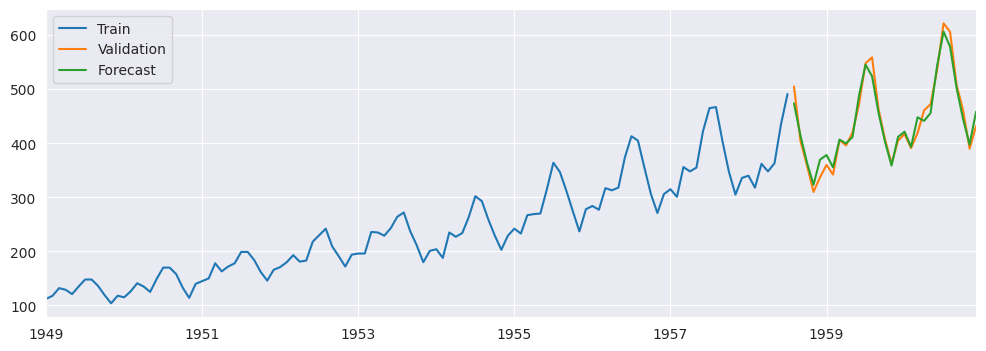

In [41]:
fig, ax = plt.subplots(figsize=(12,4))
fig = train['#Passengers'].plot(ax=ax, label='Train')
fig = validation['#Passengers'].plot(ax=ax, label='Validation')
fig = forecasts['Forecasts'].plot(ax=ax, label='Forecast')
ax.legend()